# Bayessche Hyperparameteroptimierung

## Imports

In [459]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D  
import scipy.stats as st
from sklearn.datasets import make_blobs
from sklearn.gaussian_process import GaussianProcessRegressor

## Datengrundlage

In [470]:
class Distribution:
    def __init__(self,n_components=2):
        X, truth = make_blobs(n_samples=500, centers=n_components, cluster_std = [np.random.uniform()*3 for i in range(n_components)],random_state=41)
        self.x = X[:, 0]
        self.y = X[:, 1]
        self.xx, self.yy = np.mgrid[np.min(self.x):np.max(self.x):500j, np.min(self.y):np.max(self.y):500j]
        self.kernel = st.gaussian_kde(np.vstack([self.x, self.y]))
        self.distribution = 1-((np.reshape(self.kernel(np.vstack([self.xx.ravel(), self.yy.ravel()])).T, self.xx.shape)+np.linspace(-0.005,0.002,500).reshape(500,1))**2)
        self.norm_distribution = (self.distribution-np.min(self.distribution))/(np.max(self.distribution)-np.min(self.distribution))
    
    def predict(self,xy):
        x,y = xy[0],xy[1]
        closest_x = np.argmin(np.absolute(np.linspace(np.min(self.x),np.max(self.x),500)-x))
        closest_y = np.argmin(np.absolute(np.linspace(np.min(self.y),np.max(self.y),500)-y))
        return self.norm_distribution[closest_x,closest_y]
        

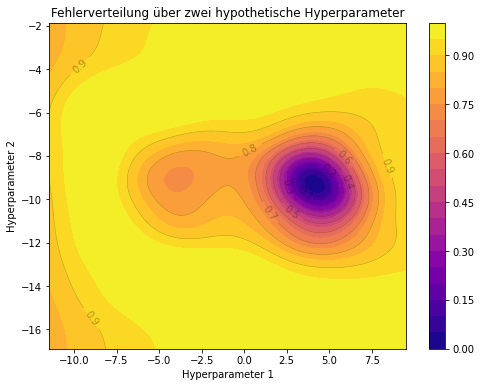

In [477]:
dis = Distribution()
plt.figure(figsize=(8,6))
plt.xlim(np.min(dis.x), np.max(dis.x))
plt.ylim(np.min(dis.y), np.max(dis.y))
cset = plt.contour(dis.xx, dis.yy, dis.norm_distribution,colors="k",levels=10,alpha=0.3,linewidths=0.5)
plt.contourf(dis.xx, dis.yy, dis.norm_distribution,levels=20,cmap="plasma")
plt.colorbar()
plt.clabel(cset, inline=1, fontsize=10)
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Fehlerverteilung über zwei hypothetische Hyperparameter')
plt.show()

## Gaussian Process Regressor

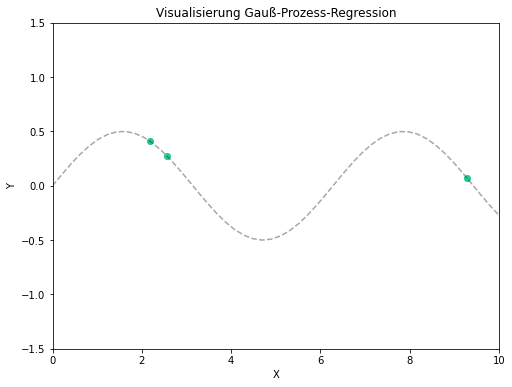

In [590]:
m = 10
n = 3
def f(x):
    return 0.5*np.sin(x)
x = np.random.uniform(0,m,n)
y = f(x)

plt.figure(figsize=(8,6))
plt.title("Visualisierung Gauß-Prozess-Regression")
plt.scatter(x,y,c="#1ACC94")
plt.plot(np.linspace(0,m),f(np.linspace(0,m)),c="#20232E",ls="--",alpha=0.4)
plt.xlim(0,m)
plt.ylim(-1.5,1.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [591]:
gpr = GaussianProcessRegressor()
gpr.fit(x.reshape(-1, 1),y)
y_pred,y_sigma = gpr.predict(np.linspace(0,m).reshape(-1, 1),return_std=True)

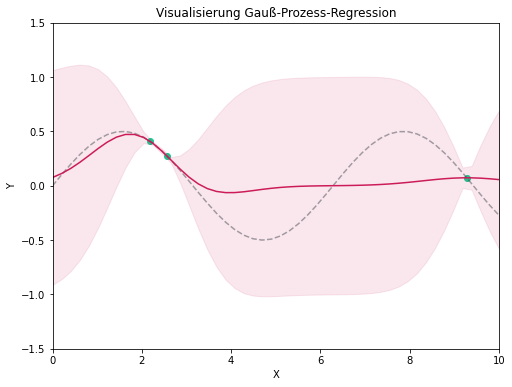

In [592]:
plt.figure(figsize=(8,6))
plt.title("Visualisierung Gauß-Prozess-Regression")
plt.scatter(x,y,c="#1ACC94")
plt.plot(np.linspace(0,m),f(np.linspace(0,m)),c="#20232E",ls="--",alpha=0.4)
plt.plot(np.linspace(0,m),y_pred,c="#CC1B58")
plt.fill_between(np.linspace(0,m), (y_pred-y_sigma), (y_pred+y_sigma), color='#CC1B58', alpha=.1)
plt.xlim(0,m)
plt.ylim(-1.5,1.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Bayessche Optimierung

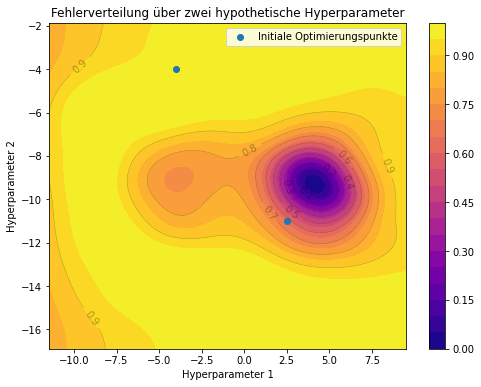

In [504]:
# Die initialen Punkte für Optimierung sind hier gegeben
initial_points = np.array([[2.5,-11],[-4,-4]])

plt.figure(figsize=(8,6))
plt.xlim(np.min(dis.x), np.max(dis.x))
plt.ylim(np.min(dis.y), np.max(dis.y))
cset = plt.contour(dis.xx, dis.yy, dis.norm_distribution,colors="k",levels=10,alpha=0.3,linewidths=0.5)
plt.contourf(dis.xx, dis.yy, dis.norm_distribution,levels=20,cmap="plasma")
plt.colorbar()
plt.scatter(initial_points[:,:1],initial_points[:,1:],label="Initiale Optimierungspunkte")
plt.clabel(cset, inline=1, fontsize=10)
plt.legend()
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Fehlerverteilung über zwei hypothetische Hyperparameter')
plt.show()

In [511]:
# Für den GaussianProcessRegressor sind normalisierte Daten geeigneter, daher hier eine Logik für die Skalierung 
scaler = MinMaxScaler().fit([[xi,yi] for xi,yi in zip(list(dis.x),list(dis.y))])
scaled_discovered = [[xi,yi] for xi,yi in scaler.transform(initial_points)]
performances = [dis.predict(p) for p in initial_points]

# Die "Zwischenmodelle" der GaussianProcessRegressors werden gespechert für spätere Visualisierung
gprs = []

# Unternimm n Optimierungsschritte
n = 100
for i in tqdm(range(n)):
    # GaussianProcessRegressor auf bekannte Trainingpunkte trainieren
    gpr = GaussianProcessRegressor()
    gpr.fit(scaled_discovered,performances)
    
    # Model zwischenspeichern
    gprs.append(gpr)

    # Eine Akquisition Funktion dient zu Bewertung, welcher Punkte besonders gut ist
    # in Abhängigkeit von erwartetem Loss und Unsicherheit ("Unbekanntheit an diesem Punkt")
    def _aquisition_function(mu,sigma,kappa=0.1):
        return mu-kappa*sigma


    # Ab hier wird der beste Punkte gesucht, dafür gibt das GPR Modell
    # für alle Punkte auf dem Grid einen vorhergesagten Loss mu sowie 
    # einen Unsicherheitswert sigma
    # Die Aquisitionfunktion setzt diese beiden Punkte ins Verhältnis
    best_point = []
    best_aquisition_function_value = np.inf

    # Jeder mögliche Punkt auf der Fläche wird getestet
    # (Diese mehrfache Iteration ist nicht die beste Implementierung, 
    # zeigt aber gut die Funktionsweise)
    for xi in np.linspace(0,1,100):
        for yi in np.linspace(0,1,100):
            # Punkt wird bewertet
            mu, sigma = gpr.predict(np.array([xi,yi]).reshape(1, -1),return_std=True)
            
            # Wenn Punkt laut Aquisition Function besser ist als der letzte, dann diesen
            # Punkt speichern
            if _aquisition_function(mu,sigma) < best_aquisition_function_value:
                best_aquisition_function_value = _aquisition_function(mu,sigma)
                best_point = [xi,yi]
                
    # An dieser Stelle ist der vielversprechendste Punkt identifiziert und kann auf der realen 
    # Distribution (dem zu optimierenden Modell) getestet werden
    # Der identifizierte Punkt und seine Performance wird den Trainigsdaten für den GPR hinzugefügt
    # für die nächste Iteration
    scaled_discovered.append([best_point[0],best_point[1]])
    unscaled = scaler.inverse_transform(np.array(best_point).reshape(1, -1))[0]
    performances.append(dis.predict(unscaled))

  0%|          | 0/100 [00:00<?, ?it/s]

Bester Punkt mit z=0.05 gefunden bei [9.364149722067918, -2.3748868820077718]


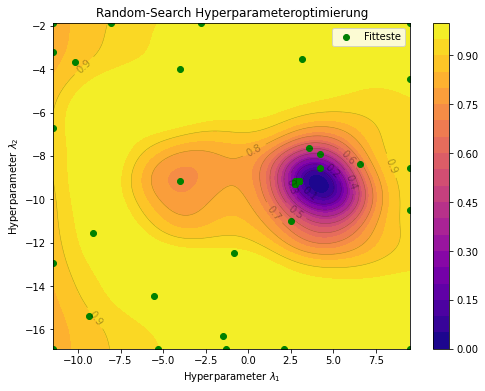

In [513]:
print("Bester Punkt mit z={:.2f} gefunden bei {}".format(best_fittnes, fittest_gene))        

discovered = np.array([[xi,yi] for xi,yi in scaler.inverse_transform(scaled_discovered)])

plt.figure(figsize=(8,6))
plt.xlim(np.min(dis.x), np.max(dis.x))
plt.ylim(np.min(dis.y), np.max(dis.y))
cset = plt.contour(dis.xx, dis.yy, dis.norm_distribution,colors="k",levels=10,alpha=0.3,linewidths=0.5)
plt.contourf(dis.xx, dis.yy, dis.norm_distribution,levels=20,cmap="plasma")
plt.colorbar()

plt.scatter(discovered[:,:1], discovered[:,1:], c="green",label="Fitteste")

plt.clabel(cset, inline=1, fontsize=10)
plt.xlabel('Hyperparameter $\lambda_1$')
plt.ylabel('Hyperparameter $\lambda_2$')
plt.title('Random-Search Hyperparameteroptimierung')
plt.legend(loc='upper right')
plt.show()

## Visualisierung der GaussianProcessRegressor Entwicklung

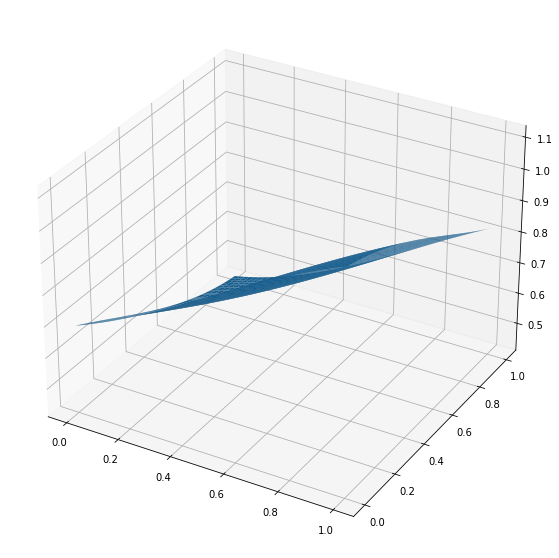

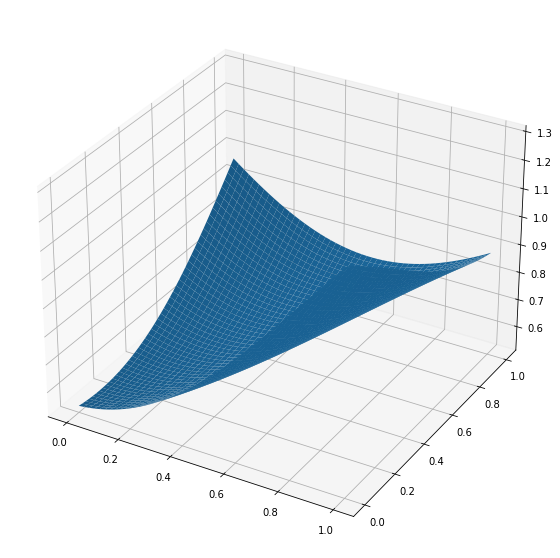

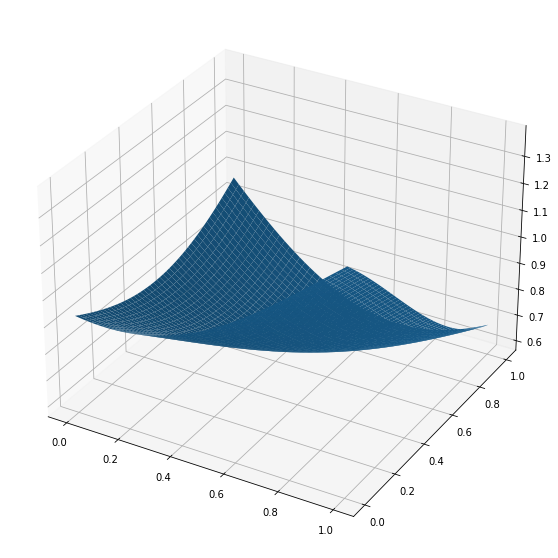

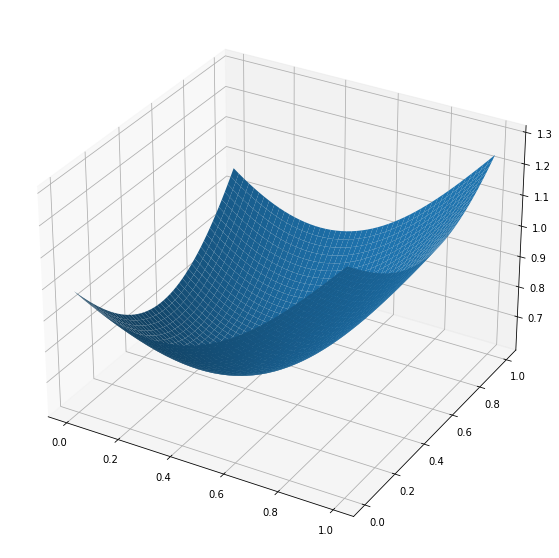

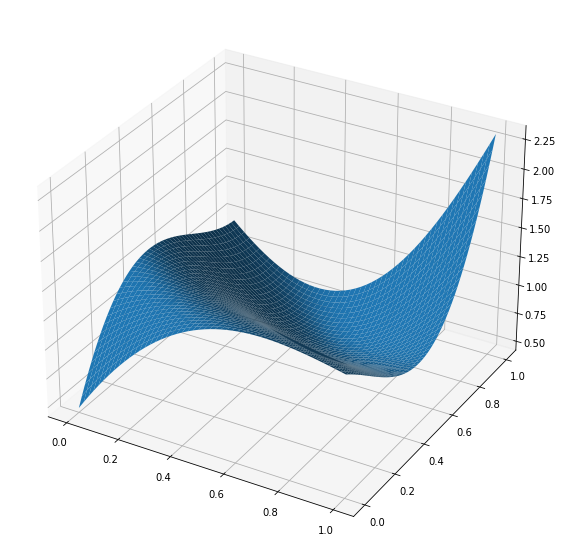

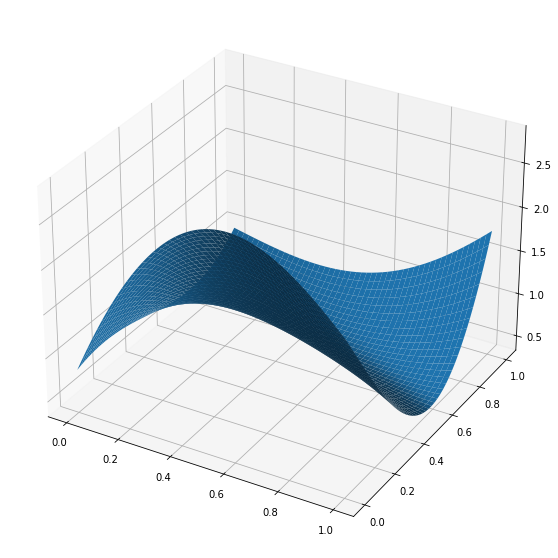

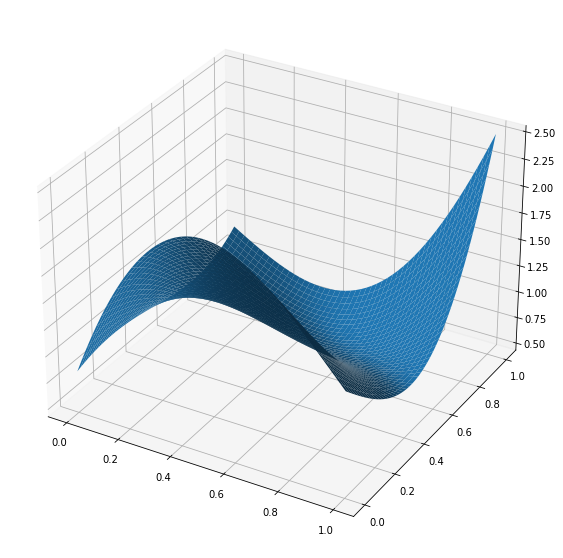

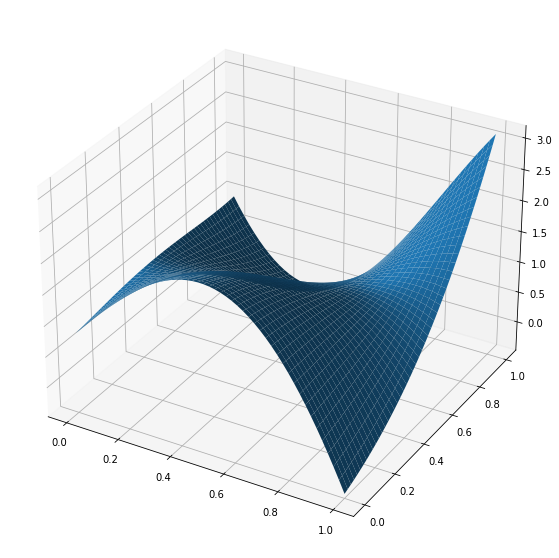

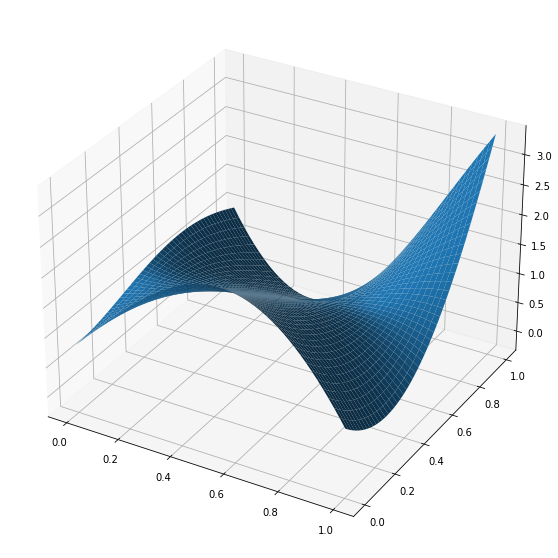

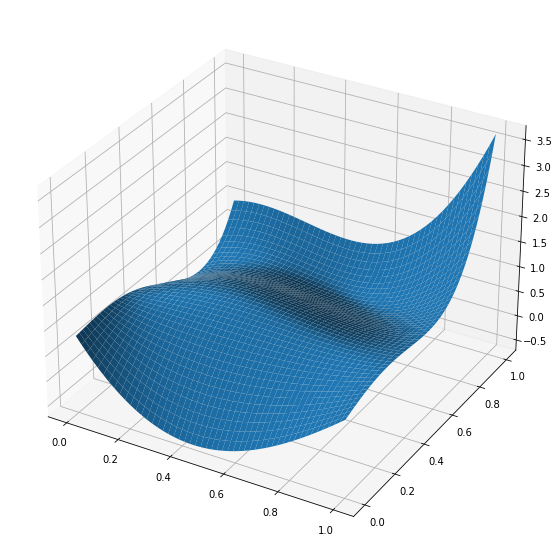

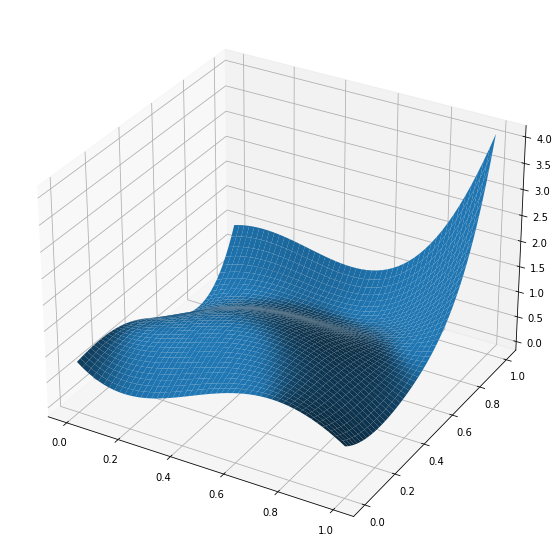

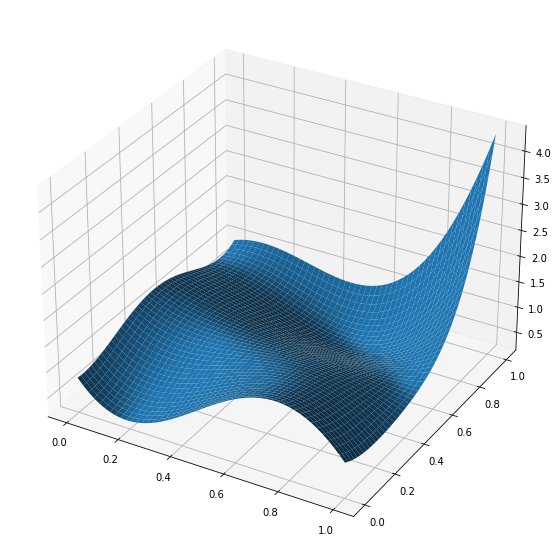

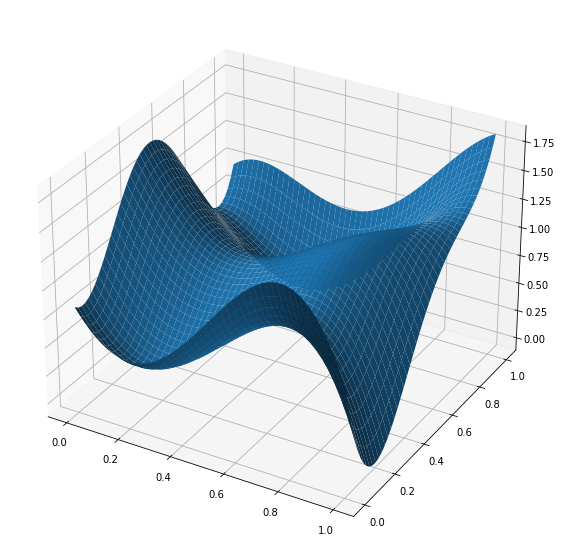

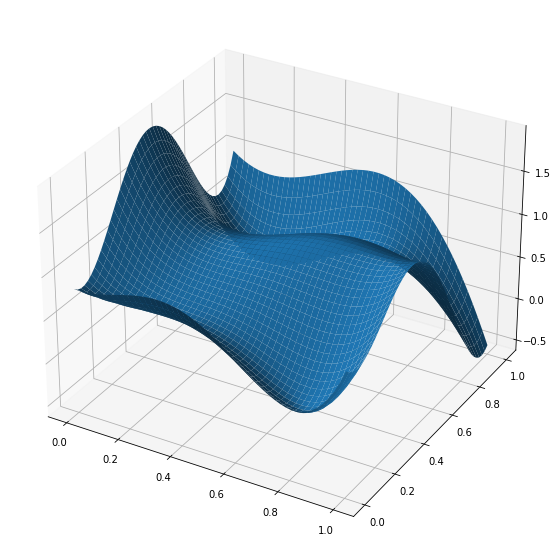

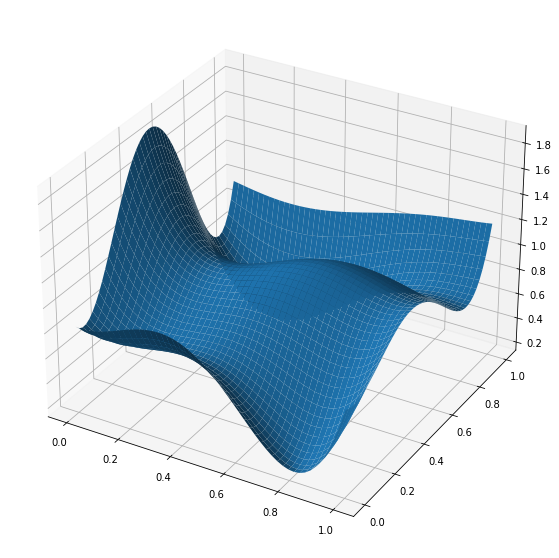

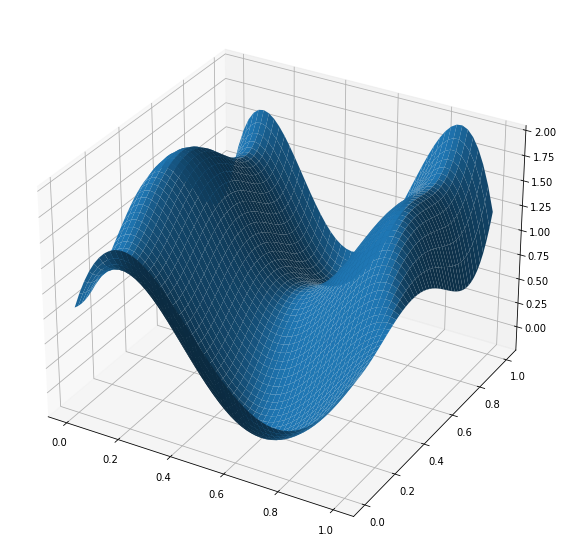

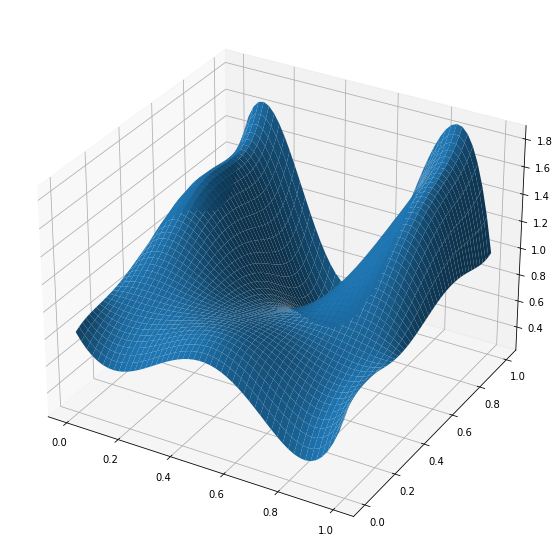

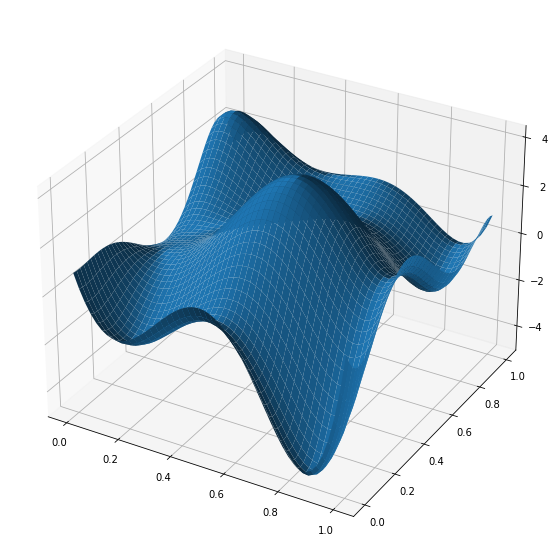

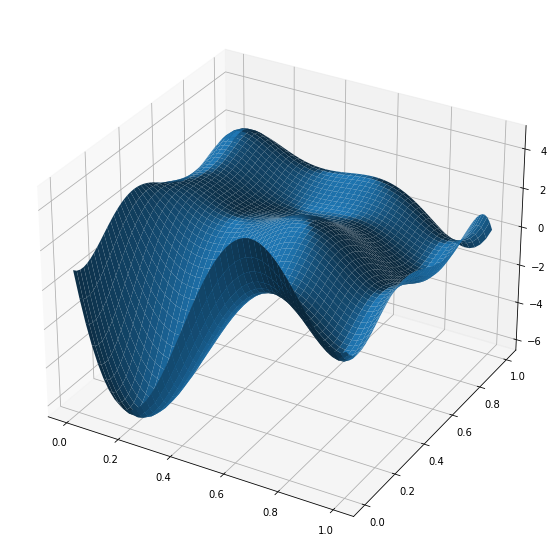

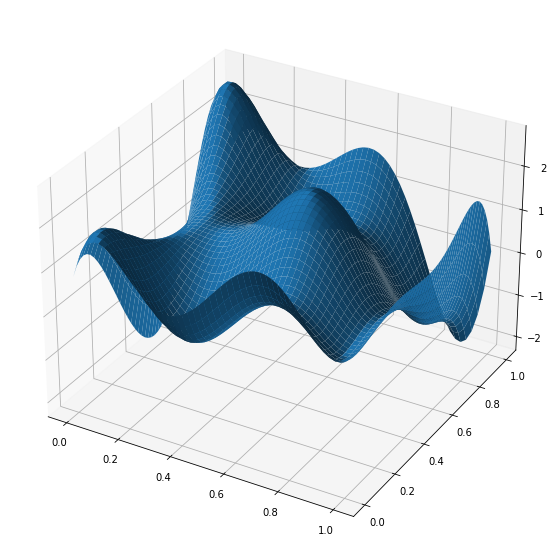

In [503]:
x,y = np.linspace(0,1), np.linspace(0,1)
xx,yy = np.meshgrid(x,y)

for gpr in gprs:
    zs = []
    for xi in x:
        for yi in y:
            zs.append(gpr.predict(np.array([xi,yi]).reshape(1, -1)).item())
            
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, np.array(zs).reshape(50,50))
    fig.show()
    